In [1]:
%env SOCCERDATA_LOGLEVEL=ERROR
%env SOCCERDATA_NOCACHE=True
%env SOCCERDATA_NOSTORE=True

env: SOCCERDATA_LOGLEVEL=ERROR
env: SOCCERDATA_NOCACHE=True
env: SOCCERDATA_NOSTORE=True


In [2]:
import soccerdata as sd

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import seaborn as sns

sns.set_context("notebook")
sns.set_style("whitegrid")

# Home team advantage in the Italian Serie A

We all know sports teams have an advantage when playing at home. Here's a look at home team advantage for 5 years of the Serie A.

In [4]:
seriea_hist = sd.MatchHistory("ITA-Serie A", range(2018, 2023))
games = seriea_hist.read_games()
games.sample(5)

date  \
league      season game                                               
ITA-Serie A 2223   2023-05-20 Cremonese-Bologna 2023-05-20 14:00:00   
            2021   2020-12-06 Crotone-Napoli    2020-12-06 17:00:00   
            1819   2019-05-26 Fiorentina-Genoa  2019-05-26 12:00:00   
            2021   2020-11-01 Udinese-Milan     2020-11-01 11:30:00   
            1819   2019-03-10 Frosinone-Torino  2019-03-10 12:00:00   

                                                  home_team away_team  FTHG  \
league      season game                                                       
ITA-Serie A 2223   2023-05-20 Cremonese-Bologna   Cremonese   Bologna     1   
            2021   2020-12-06 Crotone-Napoli        Crotone    Napoli     0   
            1819   2019-05-26 Fiorentina-Genoa   Fiorentina     Genoa     0   
            2021   2020-11-01 Udinese-Milan         Udinese     Milan     1   
            1819   2019-03-10 Frosinone-Torino    Frosinone    Torino     1   

                                                 FTAG FTR  HTHG  HTAG HTR  HS  \
league      season game                                                         
ITA-Serie A 2223   2023-05-20 Cremonese-Bologna     5   A     0     3   A  13   
            2021   2020-12-06 Crotone-Napoli        4   A     0     1   A   4   
            1819   2019-05-26 Fiorentina-Genoa      0   D     0     0   D   5   
            2021   2020-11-01 Udinese-Milan         2   A     0     1   A   7   
            1819   2019-03-10 Frosinone-Torino      2   A     1     0   H   9   

                                                 ...  AvgC<2.5  AHCh  \
league      season game                          ...                   
ITA-Serie A 2223   2023-05-20 Cremonese-Bologna  ...       1.8  0.50   
            2021   2020-12-06 Crotone-Napoli     ...       2.3  1.25   
            1819   2019-05-26 Fiorentina-Genoa   ...       NaN   NaN   
            2021   2020-11-01 Udinese-Milan      ...       2.0  0.50   
            1819   2019-03-10 Frosinone-Torino   ...       NaN   NaN   

                                                 B365CAHH  B365CAHA  PCAHH  \
league      season game                                                      
ITA-Serie A 2223   2023-05-20 Cremonese-Bologna      1.84      2.06   1.85   
            2021   2020-12-06 Crotone-Napoli         1.99      1.94   1.98   
            1819   2019-05-26 Fiorentina-Genoa        NaN       NaN    NaN   
            2021   2020-11-01 Udinese-Milan          1.95      1.98   1.93   
            1819   2019-03-10 Frosinone-Torino        NaN       NaN    NaN   

                                                 PCAHA  MaxCAHH  MaxCAHA  \
league      season game                                                    
ITA-Serie A 2223   2023-05-20 Cremonese-Bologna   2.08     1.90     2.15   
            2021   2020-12-06 Crotone-Napoli      1.94     2.03     1.96   
            1819   2019-05-26 Fiorentina-Genoa     NaN      NaN      NaN   
            2021   2020-11-01 Udinese-Milan       1.99     1.99     2.01   
            1819   2019-03-10 Frosinone-Torino     NaN      NaN      NaN   

                                                 AvgCAHH  AvgCAHA  
league      season game                                            
ITA-Serie A 2223   2023-05-20 Cremonese-Bologna     1.83     2.03  
            2021   2020-12-06 Crotone-Napoli        1.96     1.90  
            1819   2019-05-26 Fiorentina-Genoa       NaN      NaN  
            2021   2020-11-01 Udinese-Milan         1.93     1.94  
            1819   2019-03-10 Frosinone-Torino       NaN      NaN  

[5 rows x 121 columns]

In [5]:
def home_away_results(games: pd.DataFrame):
    """Returns aggregated home/away results per team"""
    res = pd.melt(
        games.reset_index(),
        id_vars=["date", "FTR"],
        value_name="team",
        var_name="is_home",
        value_vars=["home_team", "away_team"],
    )

    res.is_home = res.is_home.replace(["home_team", "away_team"], ["Home", "Away"])
    res["win"] = res["lose"] = res["draw"] = 0
    res.loc[(res["is_home"] == "Home") & (res["FTR"] == "H"), "win"] = 1
    res.loc[(res["is_home"] == "Away") & (res["FTR"] == "A"), "win"] = 1
    res.loc[(res["is_home"] == "Home") & (res["FTR"] == "A"), "lose"] = 1
    res.loc[(res["is_home"] == "Away") & (res["FTR"] == "H"), "lose"] = 1
    res.loc[res["FTR"] == "D", "draw"] = 1

    groups = res.groupby(["team", "is_home"])
    win = groups.win.agg(["sum", "mean"]).rename(columns={"sum": "n_win", "mean": "win_pct"})
    loss = groups.lose.agg(["sum", "mean"]).rename(columns={"sum": "n_lose", "mean": "lose_pct"})
    draw = groups.draw.agg(["sum", "mean"]).rename(columns={"sum": "n_draw", "mean": "draw_pct"})

    res = pd.concat([win, loss, draw], axis=1)
    return res

In [6]:
results = home_away_results(games)
results.head(6)

n_win   win_pct  n_lose  lose_pct  n_draw  draw_pct
team      is_home                                                     
Atalanta  Away        52  0.547368      16  0.168421      27  0.284211
          Home        56  0.589474      23  0.242105      16  0.168421
Benevento Away        10  0.263158      18  0.473684      10  0.263158
          Home         4  0.105263      20  0.526316      14  0.368421
Bologna   Away        22  0.231579      48  0.505263      25  0.263158
          Home        35  0.368421      29  0.305263      31  0.326316

The overall picture shows most teams have a clear advantage at home:

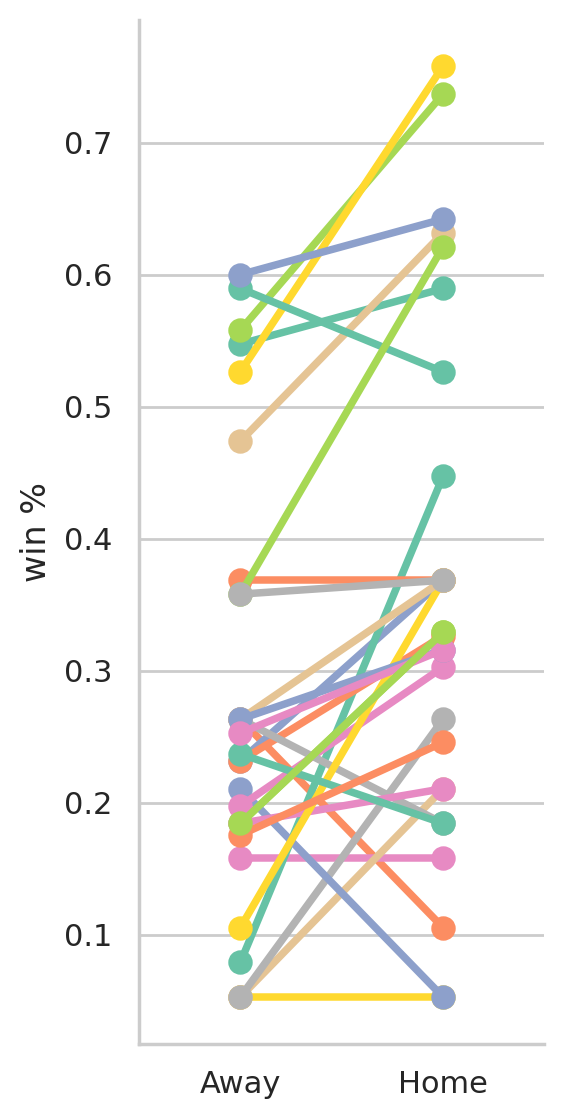

In [7]:
g = sns.FacetGrid(results.reset_index(), hue="team", palette="Set2", height=6, aspect=0.5)
g.map(sns.pointplot, "is_home", "win_pct", order=["Away", "Home"])
g.set_axis_labels("", "win %");

But there are a few exceptions.

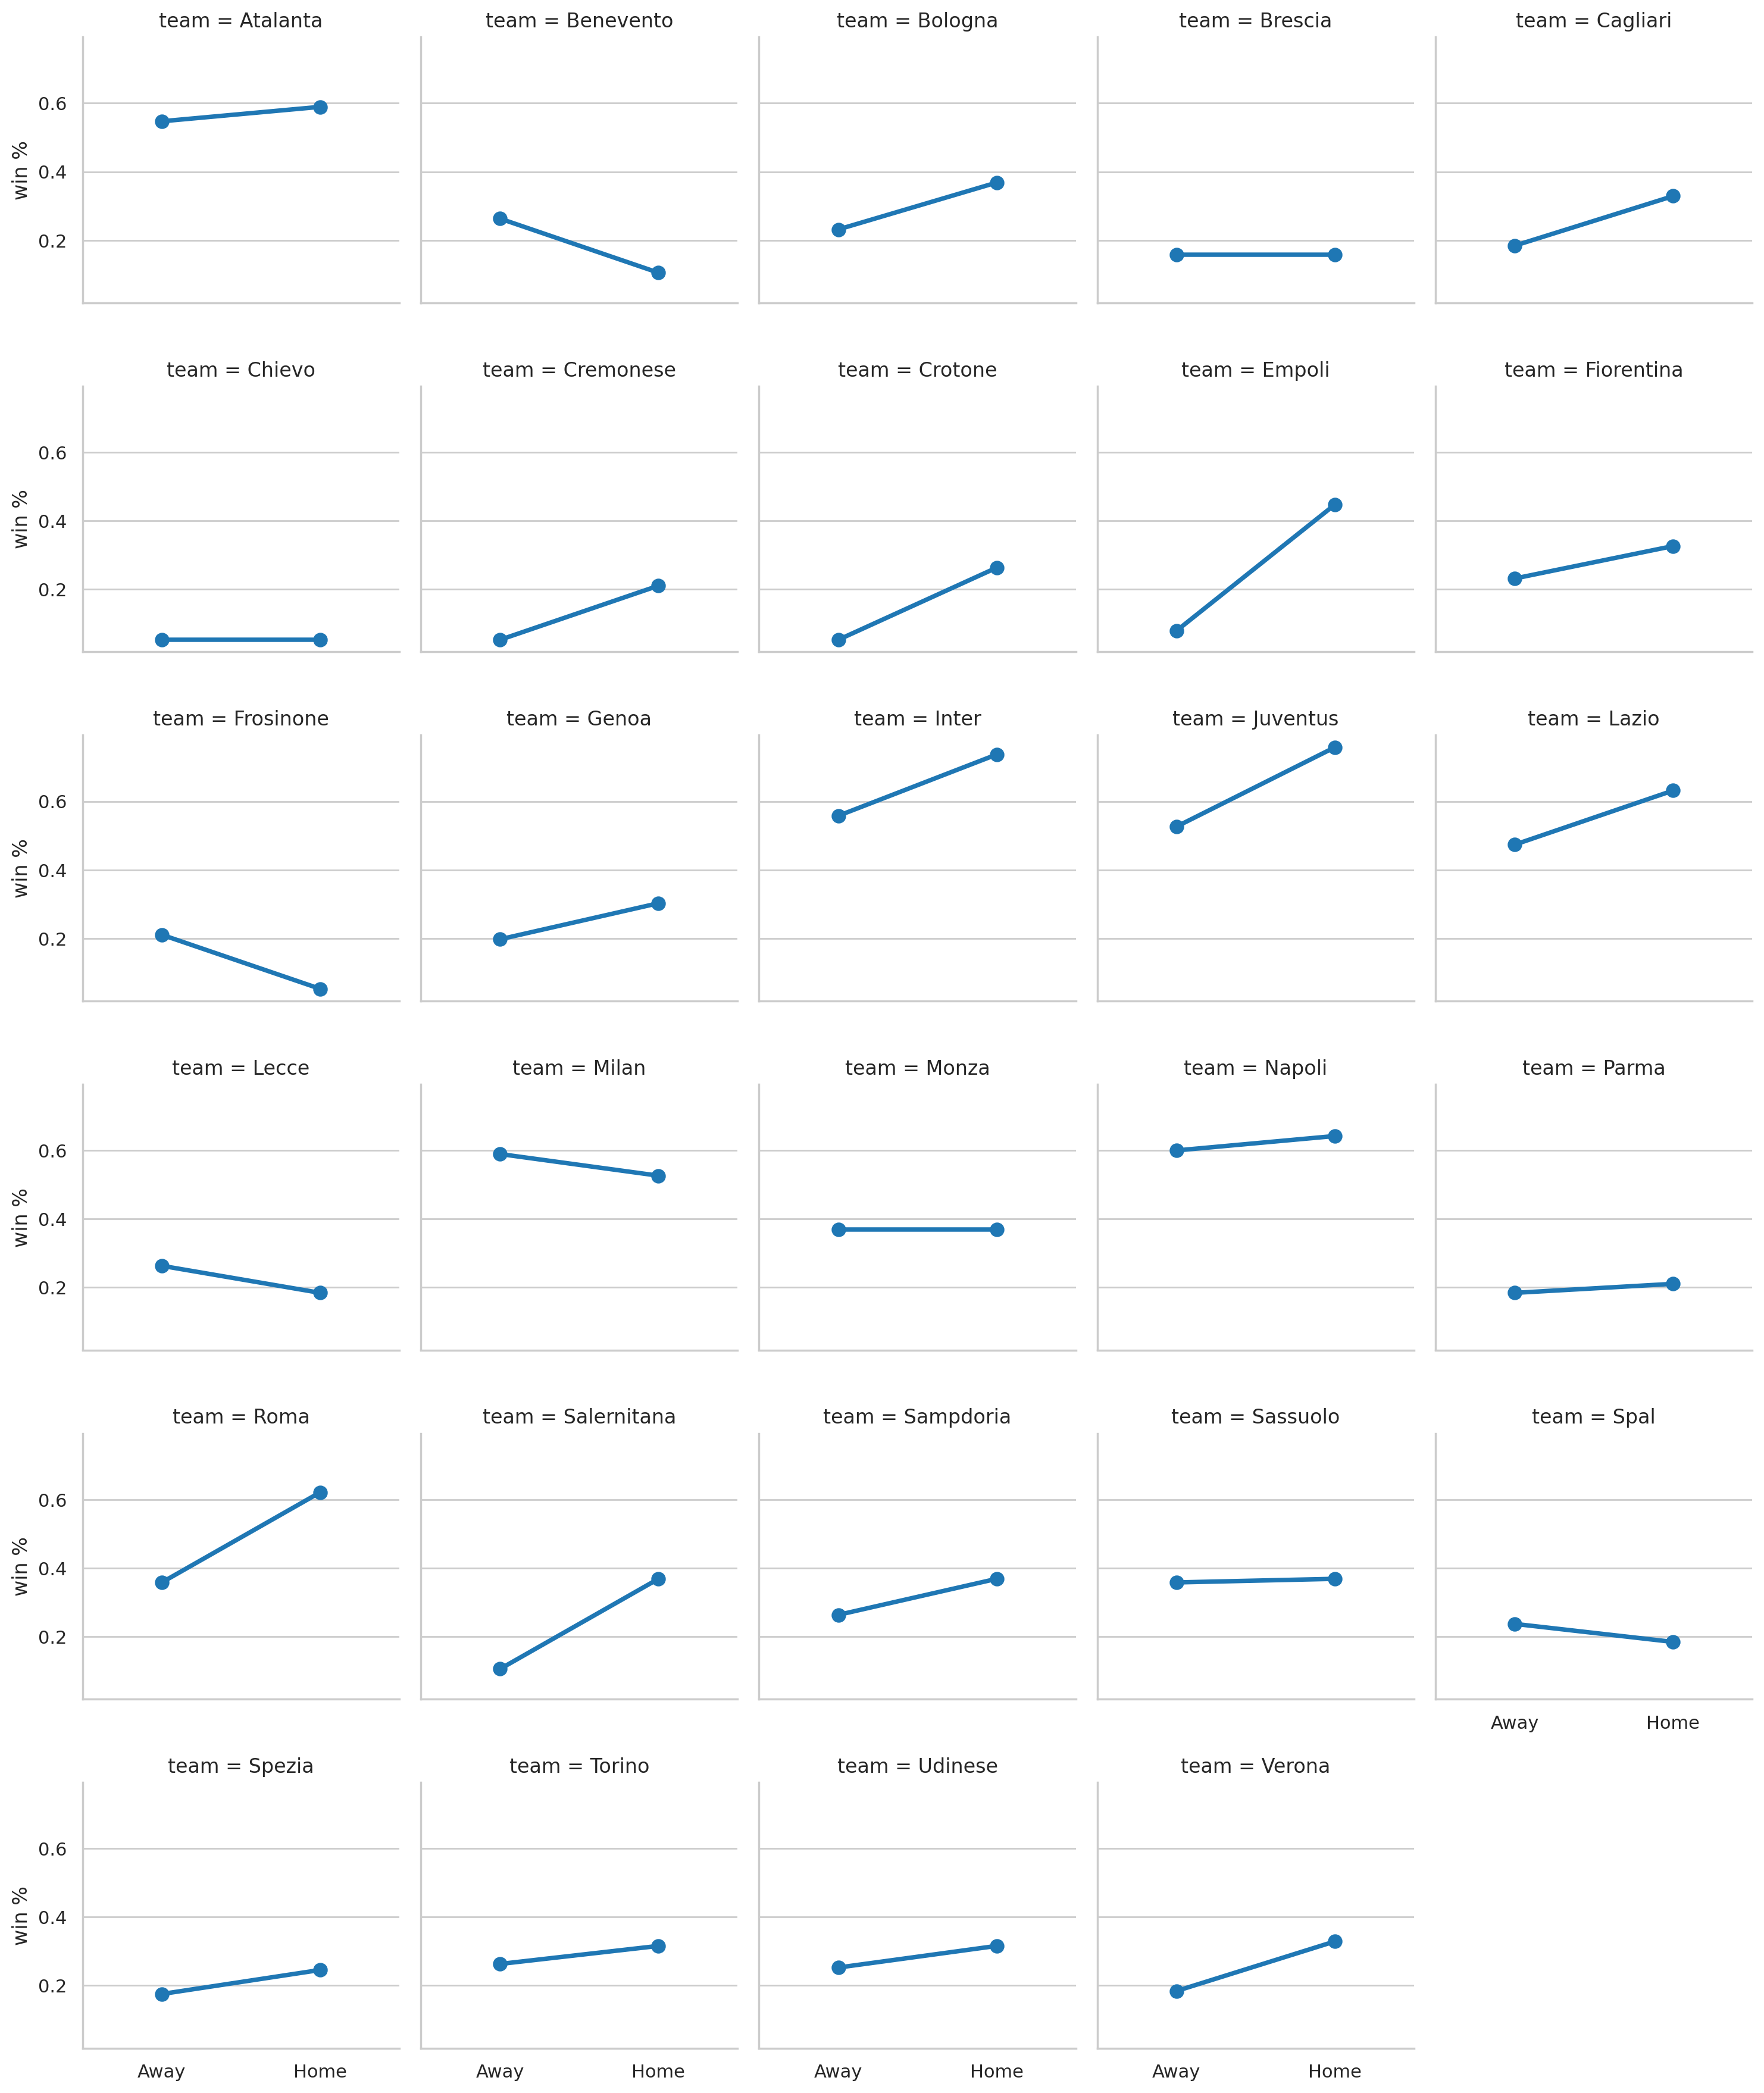

In [8]:
g = sns.FacetGrid(results.reset_index(), col="team", col_wrap=5)
g.map(sns.pointplot, "is_home", "win_pct", order=["Away", "Home"])
g.set_axis_labels("", "win %");